In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import calendar
from time import strptime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# loading dataset
df = pd.read_csv('Comcast_telecom_complaints_data.csv')

In [3]:
df

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone
0,250635,Comcast Cable Internet Speeds,22-04-15,22-Apr-15,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No
1,223441,Payment disappear - service got disconnected,04-08-15,04-Aug-15,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No
2,242732,Speed and Service,18-04-15,18-Apr-15,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,05-07-15,05-Jul-15,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes
4,307175,Comcast not working and no service to boot,26-05-15,26-May-15,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No
5,338519,ISP Charging for arbitrary data limits with ov...,06-12-15,06-Dec-15,9:59:40 PM,Internet,Acworth,Georgia,30101,Solved,No
6,361148,Throttling service and unreasonable data caps,24-06-15,24-Jun-15,10:13:55 AM,Customer Care Call,Acworth,Georgia,30101,Pending,No
7,359792,Comcast refuses to help troubleshoot and corre...,23-06-15,23-Jun-15,6:56:14 PM,Internet,Adrian,Michigan,49221,Solved,No
8,318072,Comcast extended outages,06-01-15,06-Jan-15,11:46:30 PM,Customer Care Call,Alameda,California,94502,Closed,No
9,371214,Comcast Raising Prices and Not Being Available...,28-06-15,28-Jun-15,6:46:31 PM,Customer Care Call,Alameda,California,94501,Open,Yes


In [4]:
df.dtypes

Ticket #                       object
Customer Complaint             object
Date                           object
Date_month_year                object
Time                           object
Received Via                   object
City                           object
State                          object
Zip code                        int64
Status                         object
Filing on Behalf of Someone    object
dtype: object

In [5]:
# date column is still a string, we need to parse it to a datetime format
df['parsed_date'] = pd.to_datetime(df['Date_month_year'])

2015-06-24    218
2015-06-23    190
2015-06-25     98
2015-06-26     55
2015-06-30     53
Name: parsed_date, dtype: int64


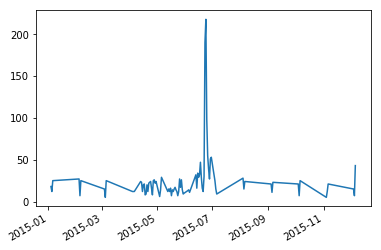

In [6]:
# Daily trend
print(df['parsed_date'].value_counts().head(5))
df['parsed_date'].value_counts().plot()

 Jun 23rd and 24th received the highest number of complaints

In [7]:
df['Year'] = pd.DatetimeIndex(df['parsed_date']).year
df['Month'] = pd.DatetimeIndex(df['parsed_date']).month
df['Month'] = df['Month'].apply(lambda x: calendar.month_abbr[x])



In [8]:
df['month_year'] = df['Month'] + df['Year'].astype(str)


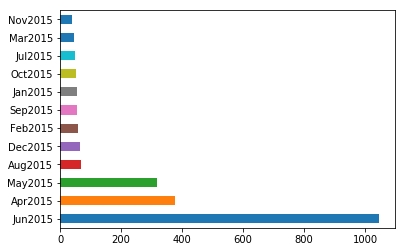

In [9]:
#Monthly trend
df['month_year'].value_counts().plot(kind="barh")


 The month of June received the maximum number of complaints

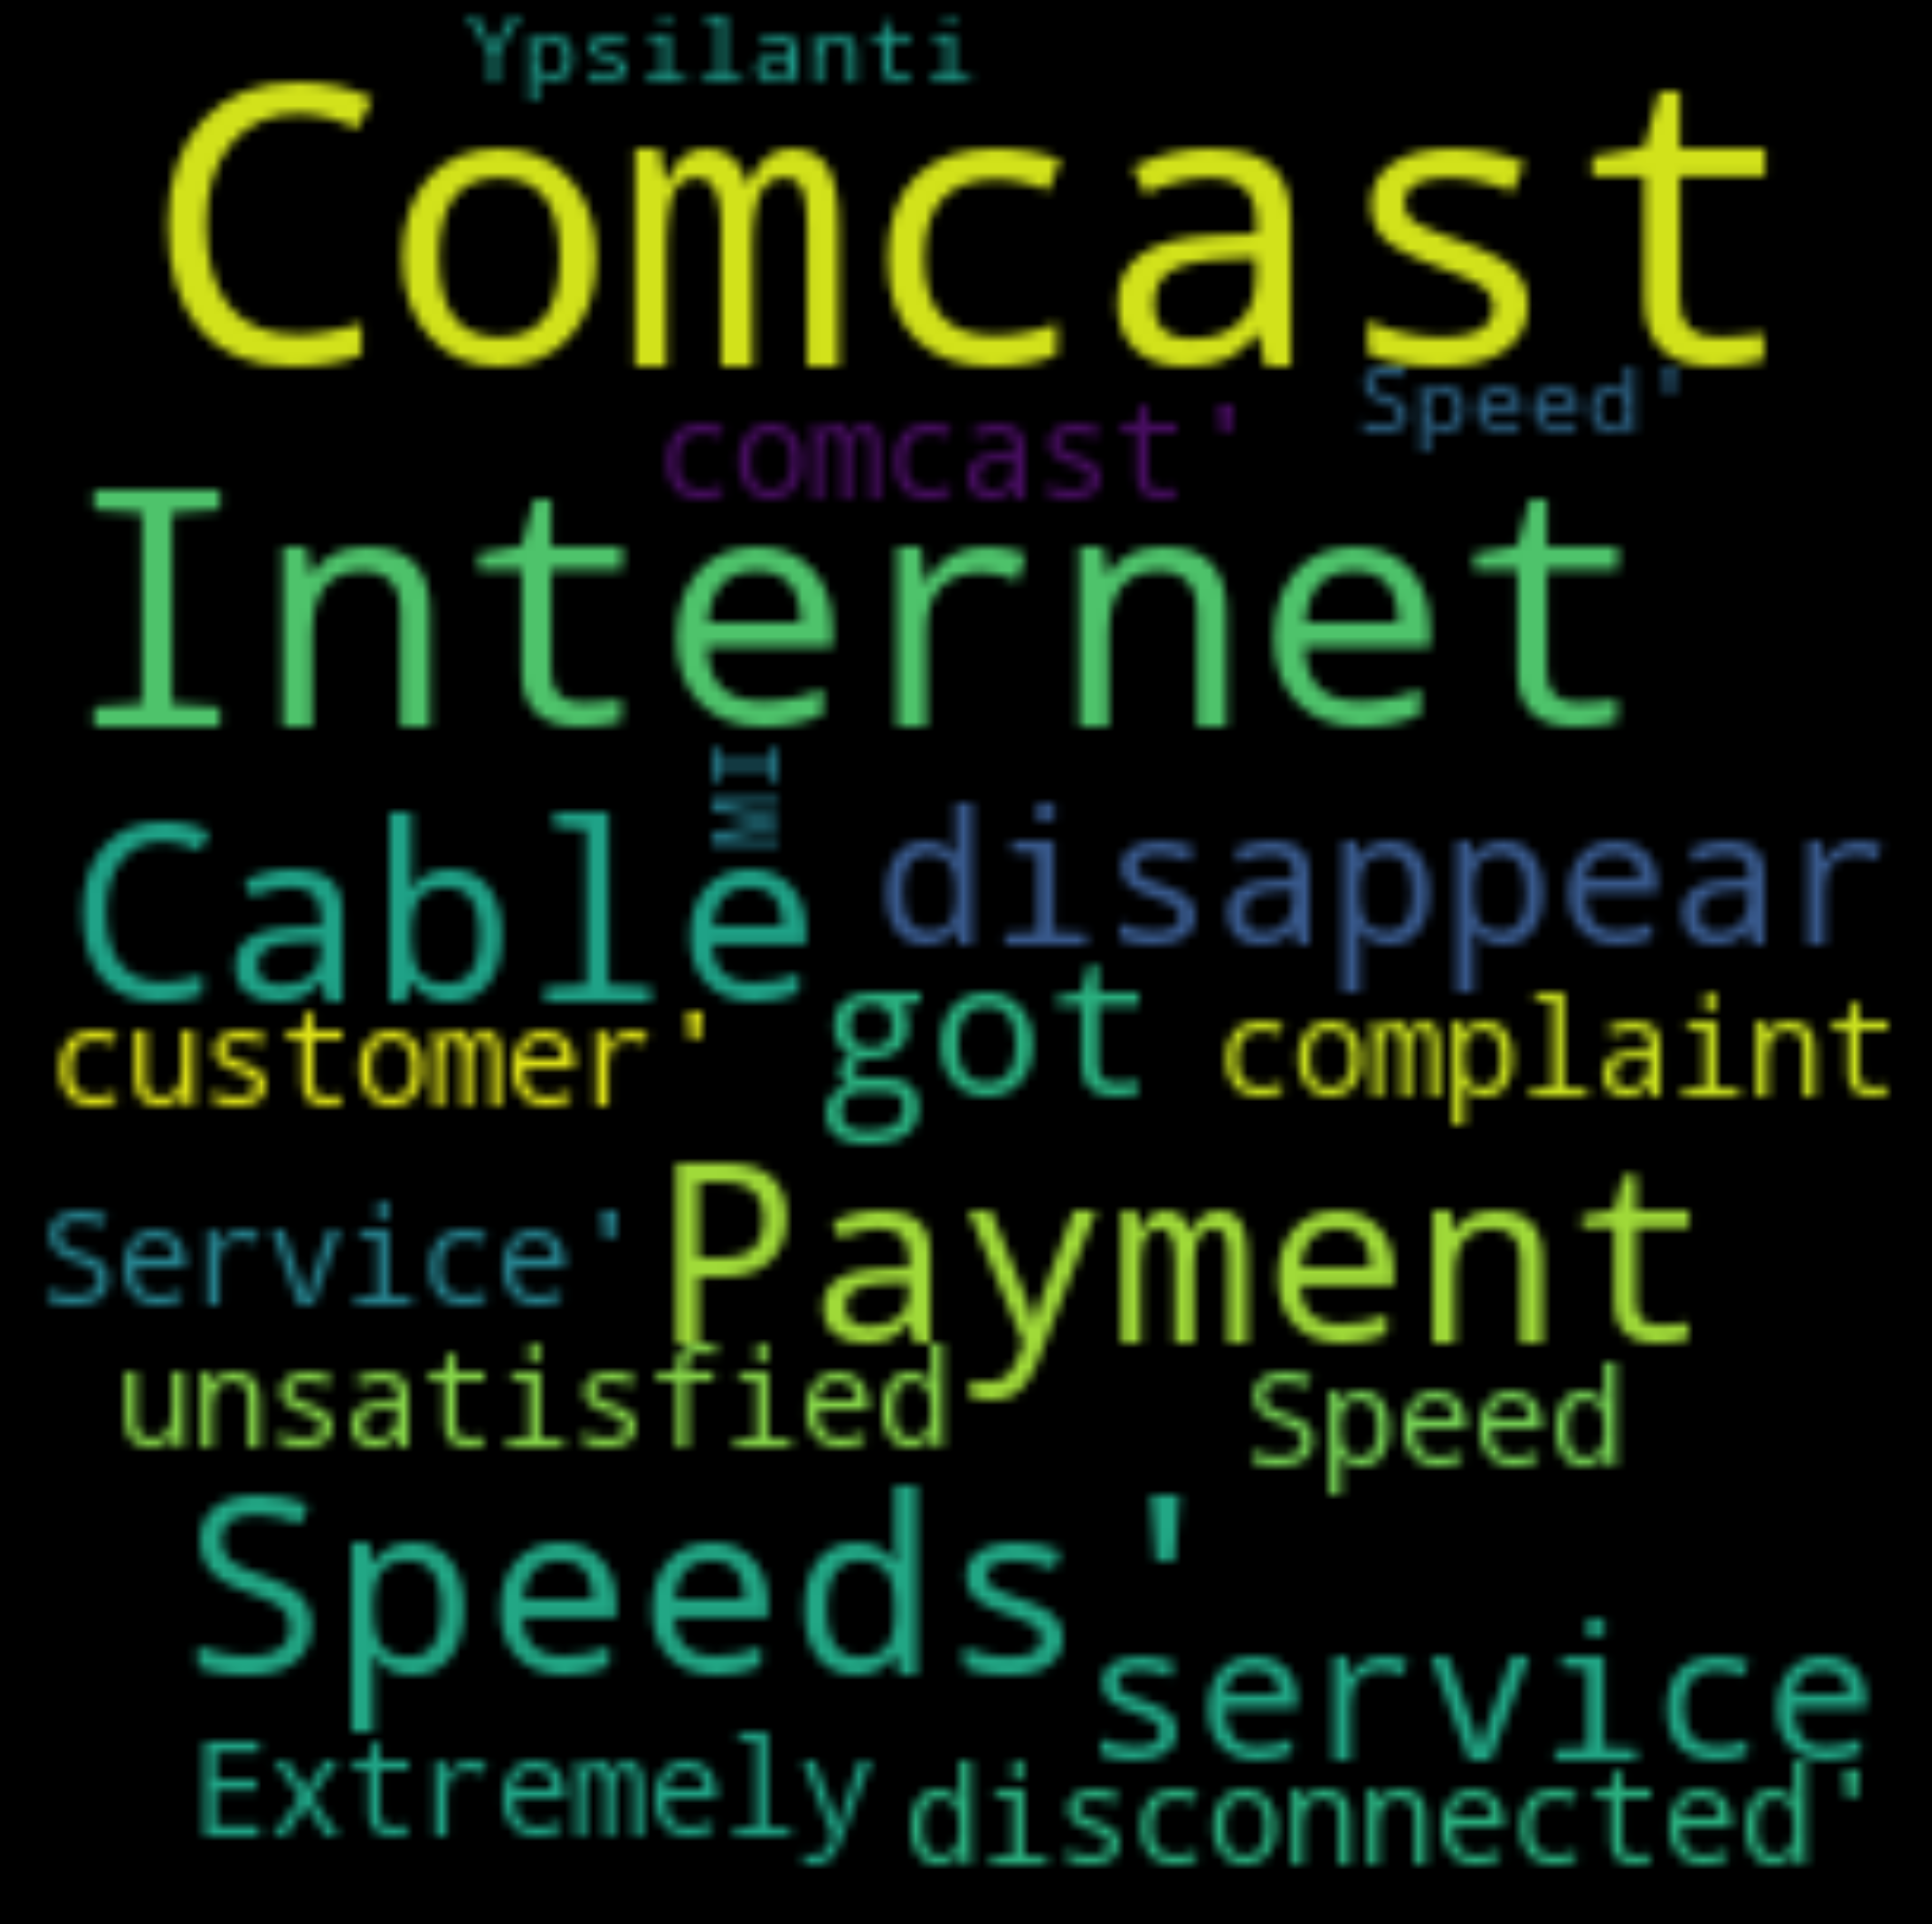

In [10]:
# Unigram wordcloud for reviews
# note: this is a rough way to estimate most common complaints 

from wordcloud import WordCloud, STOPWORDS

text = df['Customer Complaint'].values
wordcloud = WordCloud(width = 200, height = 200, background_color = 'black', stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
   
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()



By observing the above wordcloud, we can infer that most common complaints are around **Internet speed, service, and payment related issues.**

Let us verify the same using a ML model.

In [11]:
import re # We clean text using regex
from collections import defaultdict # For accumlating values
from nltk.corpus import stopwords # To remove stopwords
from gensim import corpora # To create corpus and dictionary for the LDA model
from gensim.models import LdaModel # To use the LDA model
import pyLDAvis.gensim # To visualise LDA model effectively
import pandas as pd
import nltk
import string
from nltk import pos_tag
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))


In [12]:
#load reviews
reviews = df["Customer Complaint"].tolist()

### Data Cleaning

In [13]:
#remove all punctuations
reviews = [re.sub(r'[^\w\s]','',str(item)) for item in reviews]  

# removing Stop-words
texts = [[word for word in document.lower().split() if word not in stopwords] for document in reviews]

#Taking out the less frequent words
frequency = defaultdict(int)
for text in texts:
    for token in text:
         frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1] for text in texts]

In [14]:
#Machine can’t understand words and documents as they are. So we split and vectorize them.
#Turning our text to a dictionary i.e. mapping between words and their integer ids. 

#In this representation, each word is represented by one vector, where each vector element represents a question-answer pair.
#e.g. “How many times does the word 'Payment' appear in the coprus? Twice.”


dictionary = corpora.Dictionary(texts)
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]
corpus

#if corpus reads [(0,1),(1,4)] it means Word with ID no ‘0’ occurred one time and word with id number ‘1’ occurred 4 times.

Dictionary(608 unique tokens: ['cable', 'comcast', 'internet', 'speeds', 'disconnected']...)


[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1), (7, 1)],
 [(7, 1), (8, 1)],
 [(1, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)],
 [(1, 1), (7, 1), (15, 1)],
 [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)],
 [(7, 1), (18, 1), (23, 1), (24, 1), (25, 1)],
 [(1, 1), (7, 1), (26, 1), (27, 1), (28, 1)],
 [(1, 1), (29, 1)],
 [(1, 1), (30, 1), (31, 1), (32, 1), (33, 1)],
 [(4, 1), (7, 1), (34, 1)],
 [(35, 1), (36, 1)],
 [(1, 1),
  (2, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1)],
 [(2, 1), (8, 1)],
 [(2, 1), (46, 1), (47, 1)],
 [(2, 1), (48, 1)],
 [(2, 1), (8, 1), (49, 1)],
 [(1, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1)],
 [(2, 1), (7, 1), (55, 1)],
 [(36, 1), (56, 1), (57, 1), (58, 1)],
 [(2, 1), (59, 1), (60, 1)],
 [(0, 1), (7, 2), (55, 1), (61, 1)],
 [(8, 1)],
 [(1, 1), (59, 1), (62, 1), (63, 1)],
 [(1, 1)],
 [(64, 1), (65, 1)],
 [(1, 1), (7, 1), (61, 1)],
 [(1, 1), (66, 1), (67, 1)],
 

**Topic modeling** is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents.
Latent Dirichlet Allocation (LDA) is an example of a model which is used to classify text in a document to a particular topic. 
It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.

In [15]:
#LDA MODEL

NUM_TOPICS = 9 #  This is a Assumption. You can vary this
ldamodel = LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15) #This might take some time based on num_topics and passes.

In [16]:
#Extracting Topics from the model

topics = ldamodel.show_topics()
for topic in topics:
    print(topic)
    


(0, '0.129*"cap" + 0.129*"comcast" + 0.123*"data" + 0.059*"cable" + 0.048*"false" + 0.031*"price" + 0.030*"deceptive" + 0.024*"charging" + 0.022*"advertising" + 0.018*"back"')
(1, '0.102*"internet" + 0.082*"speeds" + 0.064*"comcast" + 0.063*"slow" + 0.052*"pricing" + 0.046*"service" + 0.035*"paying" + 0.030*"comcastxfinity" + 0.023*"switch" + 0.023*"connectivity"')
(2, '0.114*"service" + 0.098*"comcast" + 0.094*"customer" + 0.035*"fees" + 0.034*"charged" + 0.030*"day" + 0.027*"account" + 0.027*"services" + 0.022*"poor" + 0.019*"horrible"')
(3, '0.114*"service" + 0.108*"comcast" + 0.077*"charges" + 0.036*"poor" + 0.029*"help" + 0.025*"lack" + 0.024*"overage" + 0.024*"cramming" + 0.024*"credit" + 0.020*"misleading"')
(4, '0.106*"service" + 0.097*"comcast" + 0.089*"internet" + 0.054*"connection" + 0.045*"charge" + 0.036*"problems" + 0.031*"terrible" + 0.024*"unreliable" + 0.024*"months" + 0.020*"fee"')
(5, '0.297*"comcast" + 0.089*"data" + 0.081*"internet" + 0.063*"caps" + 0.041*"xfinity"

In [17]:
#Above result looks too messy to understand easily. Let’s print them in a better view using pandas dataframe.

word_dict = {};
for i in range(NUM_TOPICS):
    words = ldamodel.show_topic(i, topn = 20)
    word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09
0,cap,internet,service,service,service,comcast,billing,comcast,internet
1,comcast,speeds,comcast,comcast,comcast,data,comcast,bill,speed
2,data,comcast,customer,charges,internet,internet,complaint,without,service
3,cable,slow,fees,poor,connection,caps,issues,services,services
4,false,pricing,charged,help,charge,xfinity,practices,high,outage
5,price,service,day,lack,problems,throttling,unfair,service,phone
6,deceptive,paying,account,overage,terrible,usage,service,monthly,signal
7,charging,comcastxfinity,services,cramming,unreliable,contract,issue,billed,several
8,advertising,switch,poor,credit,months,business,monopolistic,refund,availability
9,back,connectivity,horrible,misleading,fee,service,bandwidth,modem,2


Observing the above words, we could make the below initial insights. 
Tweaking number of passes and topics might yield better topics and results.

Note: Individual topic results will vary each time you run the model.

## Topic 1,5,7,8 – Comcast internet service is not reliable.  Internet speeds are not as promised.

## Topic 2,3,6,9 – Unfair billing practices

## Topic 4 – Data caps


In [18]:
#Visualization using PyLDAvis

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [19]:
# Create a new categorical variable with value as - Open and Closed. 
# Open & Pending to be categorized as 'Open' and Closed & Solved to be categorized as 'Closed'

df['Status'].unique()

array(['Closed', 'Open', 'Solved', 'Pending'], dtype=object)

In [20]:
#creating another categorical variable
df.assign(Status2="")

,Ticket #,Customer Complaint,Date,Date_month_year,Time,Received Via,City,State,Zip code,Status,Filing on Behalf of Someone,parsed_date,Year,Month,month_year,Status2
0,250635,Comcast Cable Internet Speeds,22-04-15,22-Apr-15,3:53:50 PM,Customer Care Call,Abingdon,Maryland,21009,Closed,No,2015-04-22,2015,Apr,Apr2015,
1,223441,Payment disappear - service got disconnected,04-08-15,04-Aug-15,10:22:56 AM,Internet,Acworth,Georgia,30102,Closed,No,2015-08-04,2015,Aug,Aug2015,
2,242732,Speed and Service,18-04-15,18-Apr-15,9:55:47 AM,Internet,Acworth,Georgia,30101,Closed,Yes,2015-04-18,2015,Apr,Apr2015,
3,277946,Comcast Imposed a New Usage Cap of 300GB that ...,05-07-15,05-Jul-15,11:59:35 AM,Internet,Acworth,Georgia,30101,Open,Yes,2015-07-05,2015,Jul,Jul2015,
4,307175,Comcast not working and no service to boot,26-05-15,26-May-15,1:25:26 PM,Internet,Acworth,Georgia,30101,Solved,No,2015-05-26,2015,May,May2015,
5,338519,ISP Charging for arbitrary data limits with ov...,06-12-15,06-Dec-15,9:59:40 PM,Internet,Acworth,Georgia,30101,Solved,No,2015-12-06,2015,Dec,Dec2015,
6,361148,Throttling service and unreasonable data caps,24-06-15,24-Jun-15,10:13:55 AM,Customer Care Call,Acworth,Georgia,30101,Pending,No,2015-06-24,2015,Jun,Jun2015,
7,359792,Comcast refuses to help troubleshoot and corre...,23-06-15,23-Jun-15,6:56:14 PM,Internet,Adrian,Michigan,49221,Solved,No,2015-06-23,2015,Jun,Jun2015,
8,318072,Comcast extended outages,06-01-15,06-Jan-15,11:46:30 PM,Customer Care Call,Alameda,California,94502,Closed,No,2015-01-06,2015,Jan,Jan2015,
9,371214,Comcast Raising Prices and Not Being Available...,28-06-15,28-Jun-15,6:46:31 PM,Customer Care Call,Alameda,California,94501,Open,Yes,2015-06-28,2015,Jun,Jun2015,


In [21]:
# Open & Pending to be categorized as 'Open' and Closed & Solved to be categorized as 'Closed'

df['Status2'] = ['Open' if (x == 'Open' or x =='Pending') else 'Closed' for x in df['Status']]


In [22]:
Complaint_state_count = pd.core.frame.DataFrame({"count": df.groupby(['State']).size().sort_values(ascending=False)}).reset_index()
Complaint_state_count.head(10)

#Georgia has the highest number of complaints

,State,count
0,Georgia,288
1,Florida,240
2,California,220
3,Illinois,164
4,Tennessee,143
5,Pennsylvania,130
6,Michigan,115
7,Washington,98
8,Colorado,80
9,Maryland,78


In [23]:
Status_complaint = df.groupby(['State', 'Status2']).size().unstack()
Status_complaint

Status2,Closed,Open
State,,
Alabama,17.0,9.0
Arizona,14.0,6.0
Arkansas,6.0,NaN
California,159.0,61.0
Colorado,58.0,22.0
Connecticut,9.0,3.0
Delaware,8.0,4.0
District Of Columbia,14.0,2.0
District of Columbia,1.0,NaN


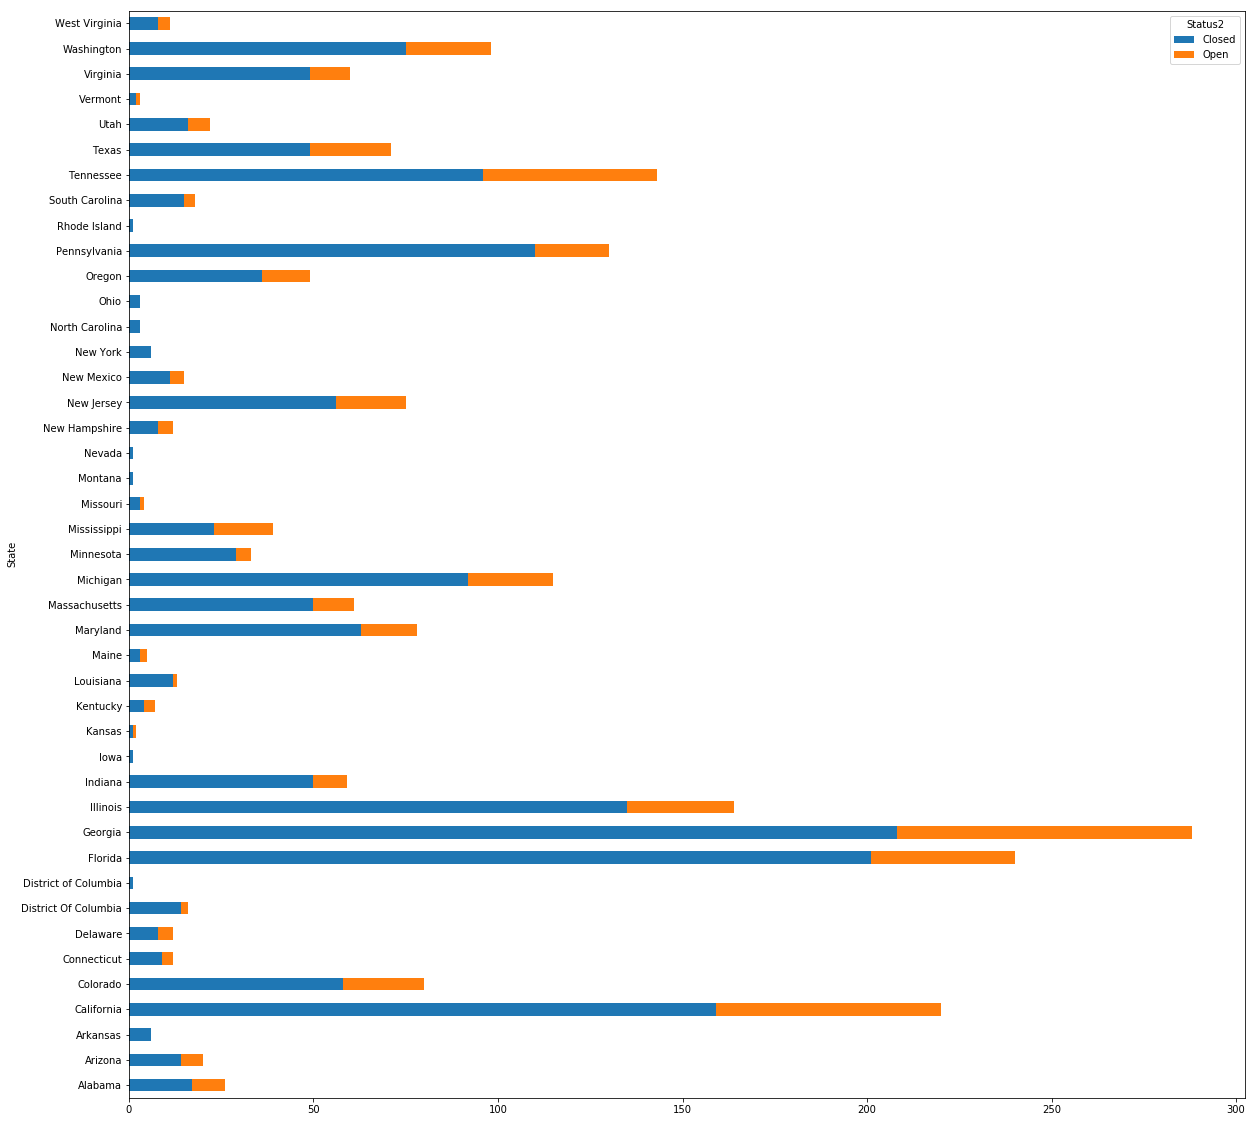

In [24]:
#State wise status of complaints in a stacked bar chart
df.groupby(['State', 'Status2']).size().unstack().plot(kind='barh',figsize=(20,20), stacked=True)



In [25]:
Percentage_unresolved = [ Status_complaint['Open'] / (Status_complaint['Open']+Status_complaint['Closed'])]
Percentage_unresolved

# kansas has the highest nymber of unresolved cases

[State
 Alabama                 0.346154
 Arizona                 0.300000
 Arkansas                     NaN
 California              0.277273
 Colorado                0.275000
 Connecticut             0.250000
 Delaware                0.333333
 District Of Columbia    0.125000
 District of Columbia         NaN
 Florida                 0.162500
 Georgia                 0.277778
 Illinois                0.176829
 Indiana                 0.152542
 Iowa                         NaN
 Kansas                  0.500000
 Kentucky                0.428571
 Louisiana               0.076923
 Maine                   0.400000
 Maryland                0.192308
 Massachusetts           0.180328
 Michigan                0.200000
 Minnesota               0.121212
 Mississippi             0.410256
 Missouri                0.250000
 Montana                      NaN
 Nevada                       NaN
 New Hampshire           0.333333
 New Jersey              0.253333
 New Mexico              0.266667
 New Yo

In [26]:
df['Received Via'].unique()

#notice that there are only two categories

array(['Customer Care Call', 'Internet'], dtype=object)

In [27]:
np1 = df.groupby(['Status2']).size()
np1

Status2
Closed    1707
Open       517
dtype: int64

In [28]:
np2 = df.groupby(['Status2']).size().sum()
np2

2224

In [29]:
percentage_resolved = np1[0]/np2*100
percentage_resolved.round()

77.0

Resolution rate is **77%** for the complaints received through Internet and customer care calls.